# Network Construction and Visualization - GTA Real Estate Hotspots

**Author:** Yadon Kassahun (Network Architect)  
**Date:** 2024-11-06  
**Purpose:** Visualize and analyze the constructed spatial networks

## Objectives
1. Load the constructed spatial network
2. Visualize network structure
3. Analyze network properties
4. Compare different edge creation methods
5. Explore spatial lag features

## Prerequisites
Run this first: `python src/network_builder.py --test`

In [1]:
# Standard libraries
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Network analysis
import networkx as nx

# Geospatial
import geopandas as gpd
import folium
from folium import plugins

# Add src to path
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.append(str(PROJECT_ROOT / 'src'))

# Import our modules
from network_builder import SpatialNetworkBuilder

# Set paths
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
RESULTS = PROJECT_ROOT / 'results'

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Imports successful")
print(f" Project root: {PROJECT_ROOT}")

 Imports successful
 Project root: /Users/kylewilliamson/Documents/gta-real-estate-hotspots


## 1. Load the Spatial Network

Let's load the network we built and examine its basic properties.

In [3]:
# Find available network files
network_dir = DATA_PROCESSED / 'networks'

if not network_dir.exists():
    print(" No networks found. Run network builder first:")
    print("   python src/network_builder.py --test")
else:
    # List available networks
    network_files = list(network_dir.glob('*.gpickle'))
    
    if not network_files:
        print(" No network files found in", network_dir)
    else:
        print(f" Found {len(network_files)} network file(s):")
        for f in network_files:
            print(f"   - {f.name}")
        
        # Load the most recent network
        latest_network = max(network_files, key=lambda p: p.stat().st_mtime)
        print(f"\n Loading: {latest_network.name}")
        
        # Load using NetworkX
        with open(latest_network, 'rb') as f:
            G = pickle.load(f)
        
        print(f"\n✓ Network loaded successfully!")
        print(f"   Nodes: {G.number_of_nodes():,}")
        print(f"   Edges: {G.number_of_edges():,}")
        print(f"   Graph type: {type(G).__name__}")

 Found 1 network file(s):
   - spatial_network_distance.gpickle

 Loading: spatial_network_distance.gpickle

✓ Network loaded successfully!
   Nodes: 99
   Edges: 165
   Graph type: Graph


In [4]:
if 'G' in locals() and G.number_of_nodes() > 0:
    print("=" * 60)
    print("NETWORK SUMMARY STATISTICS")
    print("=" * 60)
    
    # Basic stats
    print(f"\n1. Basic Properties:")
    print(f"   Nodes:              {G.number_of_nodes():,}")
    print(f"   Edges:              {G.number_of_edges():,}")
    print(f"   Density:            {nx.density(G):.4f}")
    
    # Degree statistics
    degrees = dict(G.degree())
    degree_values = list(degrees.values())
    
    print(f"\n2. Degree Statistics:")
    print(f"   Average degree:     {np.mean(degree_values):.2f}")
    print(f"   Max degree:         {np.max(degree_values)}")
    print(f"   Min degree:         {np.min(degree_values)}")
    print(f"   Median degree:      {np.median(degree_values):.0f}")
    
    # Connectivity
    print(f"\n3. Connectivity:")
    print(f"   Is connected:       {nx.is_connected(G)}")
    print(f"   Num components:     {nx.number_connected_components(G)}")
    
    if nx.is_connected(G):
        print(f"   Diameter:           {nx.diameter(G)}")
        print(f"   Avg path length:    {nx.average_shortest_path_length(G):.2f}")
    else:
        # Stats for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc).copy()
        print(f"   Largest component:  {len(largest_cc)} nodes")
        print(f"   Diameter (largest): {nx.diameter(G_largest)}")
    
    # Clustering
    print(f"\n4. Clustering:")
    avg_clustering = nx.average_clustering(G)
    print(f"   Avg clustering:     {avg_clustering:.4f}")
    
    # Edge weights (if available)
    if G.number_of_edges() > 0:
        edge_weights = [G[u][v].get('distance_km', 0) for u, v in G.edges()]
        edge_weights = [w for w in edge_weights if w > 0]
        
        if edge_weights:
            print(f"\n5. Edge Distances:")
            print(f"   Average distance:   {np.mean(edge_weights):.2f} km")
            print(f"   Max distance:       {np.max(edge_weights):.2f} km")
            print(f"   Min distance:       {np.min(edge_weights):.2f} km")
else:
    print("⚠ Network not loaded or empty")

NETWORK SUMMARY STATISTICS

1. Basic Properties:
   Nodes:              99
   Edges:              165
   Density:            0.0340

2. Degree Statistics:
   Average degree:     3.33
   Max degree:         5
   Min degree:         0
   Median degree:      3

3. Connectivity:
   Is connected:       False
   Num components:     12
   Largest component:  19 nodes
   Diameter (largest): 9

4. Clustering:
   Avg clustering:     0.6529

5. Edge Distances:
   Average distance:   3.10 km
   Max distance:       4.84 km
   Min distance:       0.00 km


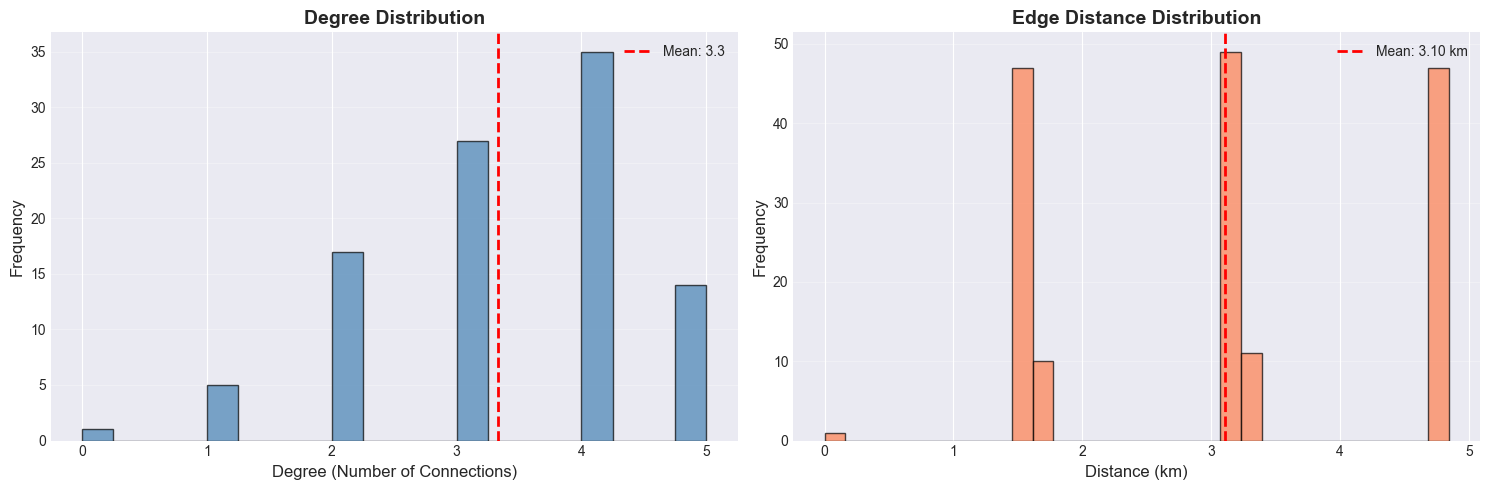

 Figure saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/figures/network_distributions.png


In [5]:
if 'G' in locals() and G.number_of_nodes() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Degree distribution histogram
    degrees = dict(G.degree())
    degree_values = list(degrees.values())
    
    axes[0].hist(degree_values, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].set_title('Degree Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Degree (Number of Connections)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].axvline(np.mean(degree_values), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(degree_values):.1f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Edge distance distribution (if available)
    edge_weights = [G[u][v].get('distance_km', 0) for u, v in G.edges()]
    edge_weights = [w for w in edge_weights if w > 0]
    
    if edge_weights:
        axes[1].hist(edge_weights, bins=30, edgecolor='black', alpha=0.7, color='coral')
        axes[1].set_title('Edge Distance Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Distance (km)', fontsize=12)
        axes[1].set_ylabel('Frequency', fontsize=12)
        axes[1].axvline(np.mean(edge_weights), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(edge_weights):.2f} km')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(RESULTS / 'figures' / 'network_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f" Figure saved to: {RESULTS / 'figures' / 'network_distributions.png'}")

## 2. Network Visualization

Let's visualize the network structure both as a graph and on a map.

Creating network graph visualization...


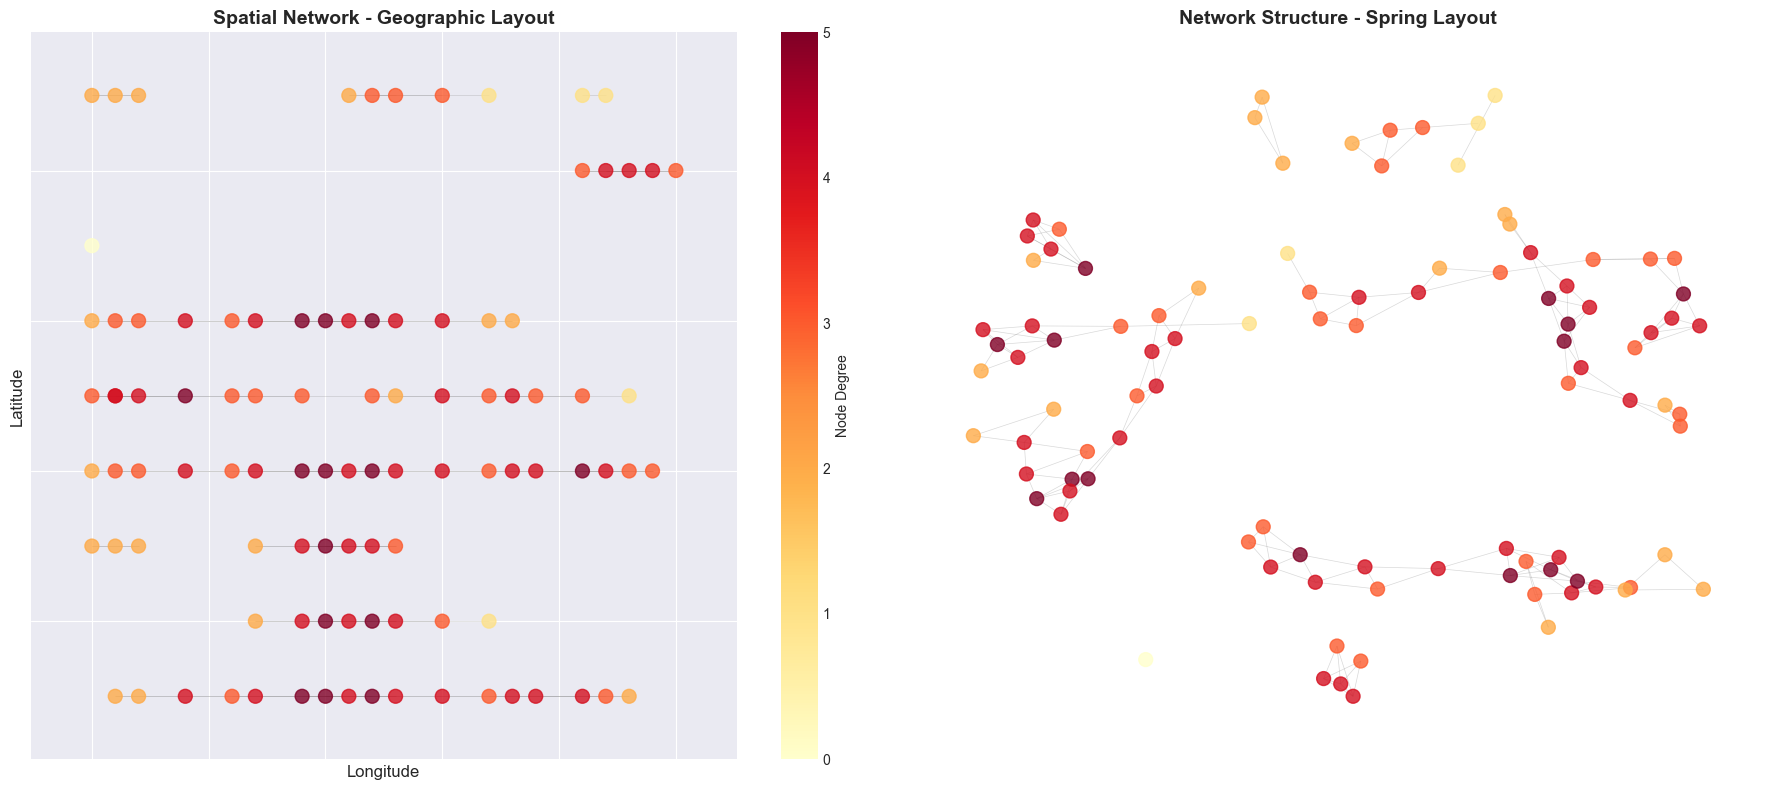

✓ Figure saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/figures/network_visualization.png

Visualization Notes:
  - Node color intensity = degree (connectivity)
  - Left: True geographic positions
  - Right: Force-directed layout (shows community structure)


In [6]:
if 'G' in locals() and G.number_of_nodes() > 0:
    print("Creating network graph visualization...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Get positions based on geographic coordinates
    pos = {}
    for node in G.nodes():
        if 'lat' in G.nodes[node] and 'lon' in G.nodes[node]:
            lat = G.nodes[node]['lat']
            lon = G.nodes[node]['lon']
            pos[node] = (lon, lat)  # Note: NetworkX uses (x, y) = (lon, lat)
    
    if len(pos) == 0:
        print("⚠ No geographic coordinates found in nodes. Using spring layout.")
        pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Plot 1: Network with geographic layout
    node_colors = list(degrees.values())
    
    nx.draw_networkx_nodes(
        G, pos, 
        node_color=node_colors,
        node_size=100,
        cmap='YlOrRd',
        alpha=0.8,
        ax=axes[0]
    )
    
    nx.draw_networkx_edges(
        G, pos,
        alpha=0.3,
        width=0.5,
        edge_color='gray',
        ax=axes[0]
    )
    
    axes[0].set_title('Spatial Network - Geographic Layout', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Longitude', fontsize=12)
    axes[0].set_ylabel('Latitude', fontsize=12)
    axes[0].axis('on')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(
        cmap='YlOrRd',
        norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[0])
    cbar.set_label('Node Degree', fontsize=10)
    
    # Plot 2: Force-directed layout (better for seeing structure)
    pos_spring = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
    
    nx.draw_networkx_nodes(
        G, pos_spring,
        node_color=node_colors,
        node_size=100,
        cmap='YlOrRd',
        alpha=0.8,
        ax=axes[1]
    )
    
    nx.draw_networkx_edges(
        G, pos_spring,
        alpha=0.3,
        width=0.5,
        edge_color='gray',
        ax=axes[1]
    )
    
    axes[1].set_title('Network Structure - Spring Layout', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(RESULTS / 'figures' / 'network_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Figure saved to: {RESULTS / 'figures' / 'network_visualization.png'}")
    print("\nVisualization Notes:")
    print("  - Node color intensity = degree (connectivity)")
    print("  - Left: True geographic positions")
    print("  - Right: Force-directed layout (shows community structure)")
else:
    print("⚠ Network not available for visualization")

In [7]:
if 'G' in locals() and G.number_of_nodes() > 0:
    print("Creating interactive network map...")
    
    # Check if nodes have coordinates
    nodes_with_coords = [node for node in G.nodes() 
                        if 'lat' in G.nodes[node] and 'lon' in G.nodes[node]]
    
    if len(nodes_with_coords) == 0:
        print(" No nodes with geographic coordinates found.")
    else:
        # Calculate center
        lats = [G.nodes[node]['lat'] for node in nodes_with_coords]
        lons = [G.nodes[node]['lon'] for node in nodes_with_coords]
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        
        # Create base map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=11,
            tiles='CartoDB positron'
        )
        
        # Add edges first (so they appear behind nodes)
        print(f"Adding {G.number_of_edges()} edges to map...")
        for u, v in G.edges():
            if u in nodes_with_coords and v in nodes_with_coords:
                coords = [
                    [G.nodes[u]['lat'], G.nodes[u]['lon']],
                    [G.nodes[v]['lat'], G.nodes[v]['lon']]
                ]
                
                # Get edge weight for line thickness
                weight = G[u][v].get('distance_km', 1.0)
                
                folium.PolyLine(
                    coords,
                    color='blue',
                    weight=1,
                    opacity=0.3
                ).add_to(m)
        
        # Add nodes
        print(f"Adding {len(nodes_with_coords)} nodes to map...")
        for node in nodes_with_coords:
            lat = G.nodes[node]['lat']
            lon = G.nodes[node]['lon']
            degree = G.degree(node)
            
            # Create popup text
            popup_text = f"""
            <b>Node:</b> {node}<br>
            <b>Degree:</b> {degree}<br>
            <b>Lat:</b> {lat:.4f}<br>
            <b>Lon:</b> {lon:.4f}<br>
            """
            
            # Add attributes if available
            for attr in ['price_mean', 'Permit_Count', 'Total_Construction_Value']:
                if attr in G.nodes[node]:
                    value = G.nodes[node][attr]
                    if pd.notna(value):
                        popup_text += f"<b>{attr}:</b> {value:,.0f}<br>"
            
            # Size based on degree
            radius = 5 + (degree * 2)
            
            folium.CircleMarker(
                location=[lat, lon],
                radius=radius,
                popup=folium.Popup(popup_text, max_width=300),
                color='red',
                fill=True,
                fillColor='red',
                fillOpacity=0.6
            ).add_to(m)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        # Save map
        map_file = RESULTS / 'figures' / 'network_map.html'
        m.save(str(map_file))
        
        print(f"\n Interactive map saved to: {map_file}")
        print(f" Open in browser: file://{map_file.absolute()}")
        
        # Display in notebook
        display(m)

Creating interactive network map...
Adding 165 edges to map...
Adding 99 nodes to map...

 Interactive map saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/figures/network_map.html
 Open in browser: file:///Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/figures/network_map.html


## 3. Node Centrality Analysis

Centrality measures identify the most "important" nodes in the network.

In [8]:
if 'G' in locals() and G.number_of_nodes() > 0:
    print("Calculating centrality measures...")
    print("(This may take a moment for large networks)\n")
    
    # Degree centrality (already calculated)
    degree_cent = nx.degree_centrality(G)
    
    # Betweenness centrality (how often a node is on shortest paths)
    print("Computing betweenness centrality...")
    betweenness_cent = nx.betweenness_centrality(G)
    
    # Closeness centrality (how close to all other nodes)
    if nx.is_connected(G):
        print("Computing closeness centrality...")
        closeness_cent = nx.closeness_centrality(G)
    else:
        print("Graph not connected. Computing closeness for largest component...")
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc).copy()
        closeness_cent = nx.closeness_centrality(G_largest)
        # Fill in zeros for nodes not in largest component
        for node in G.nodes():
            if node not in closeness_cent:
                closeness_cent[node] = 0
    
    # Eigenvector centrality (influence based on connections to other influential nodes)
    print("Computing eigenvector centrality...")
    try:
        eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)
    except:
        print(" Eigenvector centrality failed (graph may not be connected)")
        eigenvector_cent = {node: 0 for node in G.nodes()}
    
    # Create summary DataFrame
    centrality_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Degree_Centrality': [degree_cent[node] for node in G.nodes()],
        'Betweenness_Centrality': [betweenness_cent[node] for node in G.nodes()],
        'Closeness_Centrality': [closeness_cent[node] for node in G.nodes()],
        'Eigenvector_Centrality': [eigenvector_cent[node] for node in G.nodes()]
    })
    
    print("\n✓ Centrality measures calculated")
    print("\nTop 10 nodes by Degree Centrality:")
    display(centrality_df.nlargest(10, 'Degree_Centrality'))
    
    print("\nTop 10 nodes by Betweenness Centrality:")
    display(centrality_df.nlargest(10, 'Betweenness_Centrality'))
    
    # Save to file
    centrality_file = RESULTS / 'tables' / 'node_centrality.csv'
    centrality_df.to_csv(centrality_file, index=False)
    print(f"\n✓ Centrality data saved to: {centrality_file}")

Calculating centrality measures...
(This may take a moment for large networks)

Computing betweenness centrality...
Graph not connected. Computing closeness for largest component...
Computing eigenvector centrality...
 Eigenvector centrality failed (graph may not be connected)

✓ Centrality measures calculated

Top 10 nodes by Degree Centrality:


,Node,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality,Eigenvector_Centrality
6,M1J,0.05102,0.005909,0.000000,0
7,M1K,0.05102,0.004839,0.000000,0
9,M1M,0.05102,0.008837,0.000000,0
20,M2K,0.05102,0.000771,0.000000,0
22,M2M,0.05102,0.001192,0.000000,0
31,M3K,0.05102,0.000491,0.000000,0
41,M4J,0.05102,0.007627,0.360000,0
42,M4K,0.05102,0.006487,0.360000,0
44,M4M,0.05102,0.011344,0.382979,0
50,M4V,0.05102,0.006908,0.276923,0



Top 10 nodes by Betweenness Centrality:


,Node,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality,Eigenvector_Centrality
46,M4P,0.040816,0.016200,0.367347,0
11,M1P,0.040816,0.012624,0.000000,0
60,M5J,0.030612,0.011782,0.000000,0
61,M5M,0.030612,0.011782,0.000000,0
44,M4M,0.051020,0.011344,0.382979,0
48,M4S,0.040816,0.010765,0.327273,0
63,M5P,0.040816,0.010520,0.000000,0
38,M4E,0.040816,0.009468,0.272727,0
57,M5E,0.051020,0.009257,0.000000,0
9,M1M,0.051020,0.008837,0.000000,0



✓ Centrality data saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/tables/node_centrality.csv


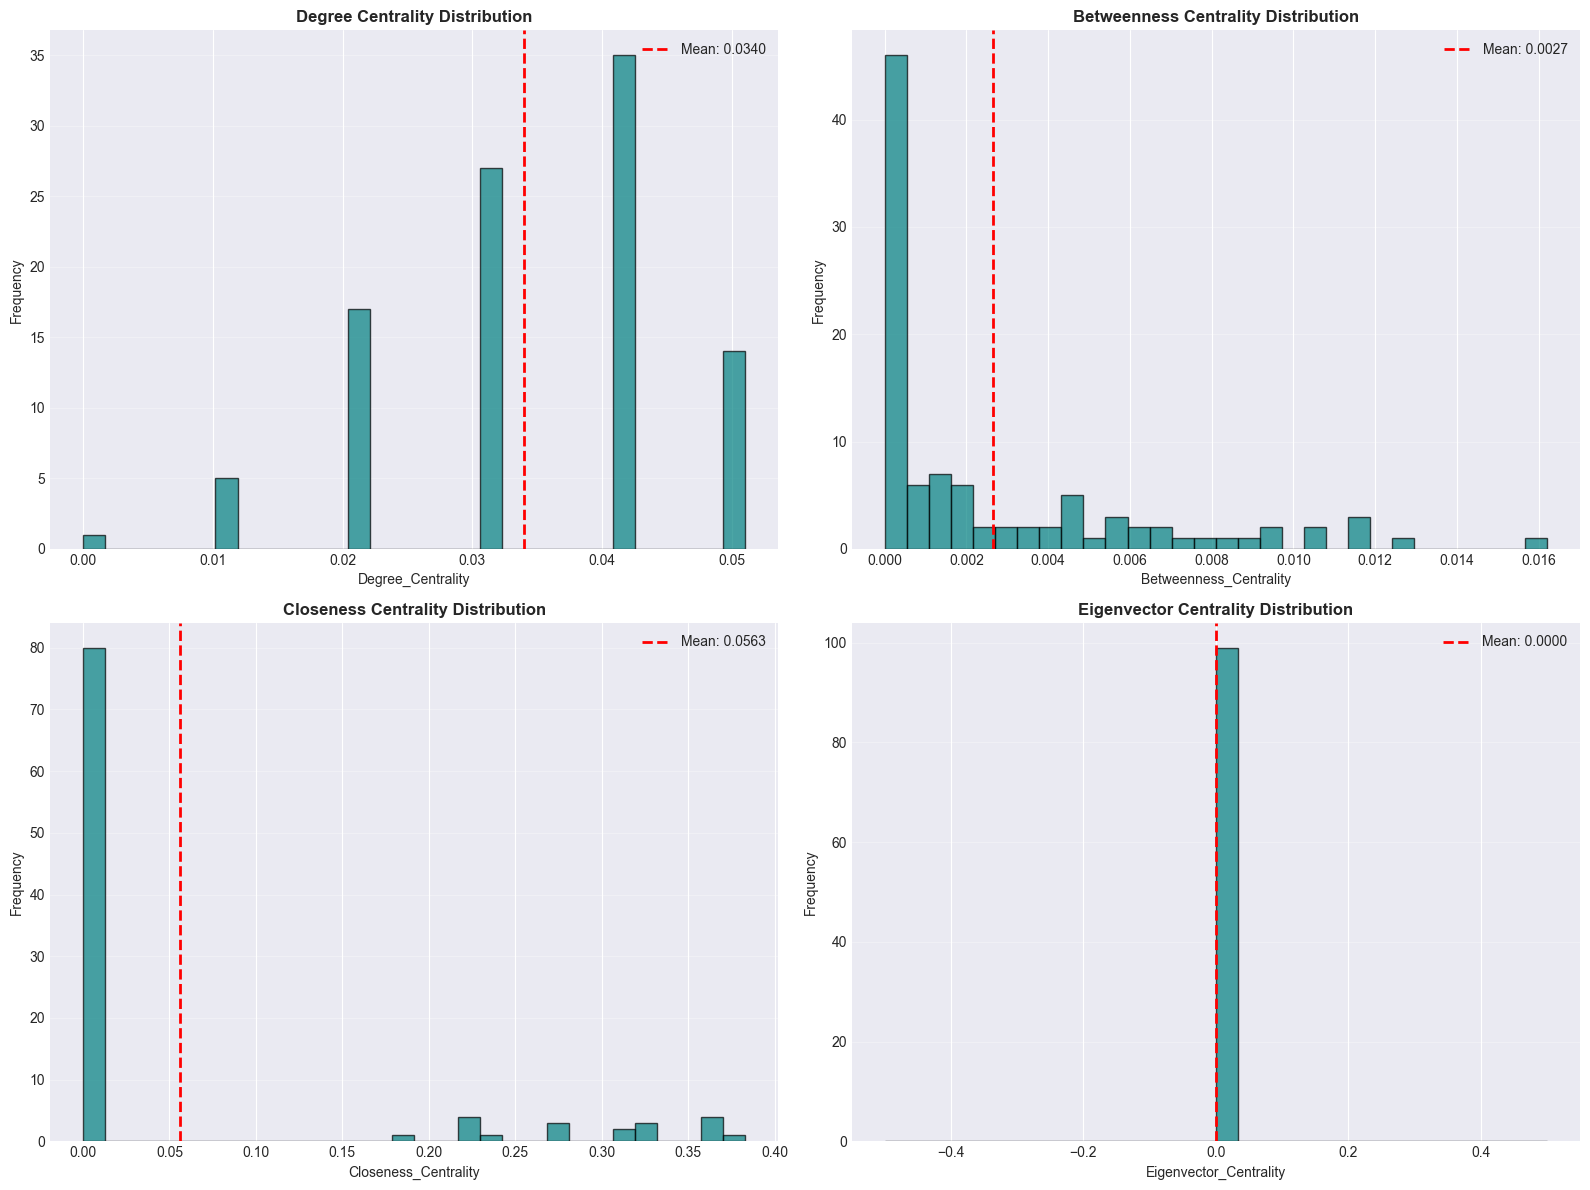

✓ Figure saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/figures/centrality_distributions.png


In [9]:
if 'centrality_df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    measures = ['Degree_Centrality', 'Betweenness_Centrality', 
                'Closeness_Centrality', 'Eigenvector_Centrality']
    titles = ['Degree Centrality', 'Betweenness Centrality', 
              'Closeness Centrality', 'Eigenvector Centrality']
    
    for idx, (measure, title) in enumerate(zip(measures, titles)):
        row = idx // 2
        col = idx % 2
        
        # Histogram
        axes[row, col].hist(centrality_df[measure], bins=30, 
                           edgecolor='black', alpha=0.7, color='teal')
        axes[row, col].set_title(f'{title} Distribution', fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel(measure, fontsize=10)
        axes[row, col].set_ylabel('Frequency', fontsize=10)
        axes[row, col].axvline(centrality_df[measure].mean(), color='red', 
                              linestyle='--', linewidth=2, 
                              label=f'Mean: {centrality_df[measure].mean():.4f}')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(RESULTS / 'figures' / 'centrality_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Figure saved to: {RESULTS / 'figures' / 'centrality_distributions.png'}")

## 4. Spatial Lag Features

Examine the spatial lag features created by the network builder.

Analyzing spatial lag features...

✓ Found 2 spatial lag feature(s):
   - Permit_Count_spatial_lag
   - Total_Construction_Value_spatial_lag

Feature: Permit_Count

Summary Statistics:
       Permit_Count  Permit_Count_spatial_lag
count     98.000000                 98.000000
mean      93.214286                 96.609262
std       61.204617                 50.709419
min       11.000000                 23.000000
25%       53.000000                 66.398712
50%       77.000000                 86.757851
75%      123.500000                121.336176
max      437.000000                391.701842

Correlation between Permit_Count and its spatial lag: 0.1812


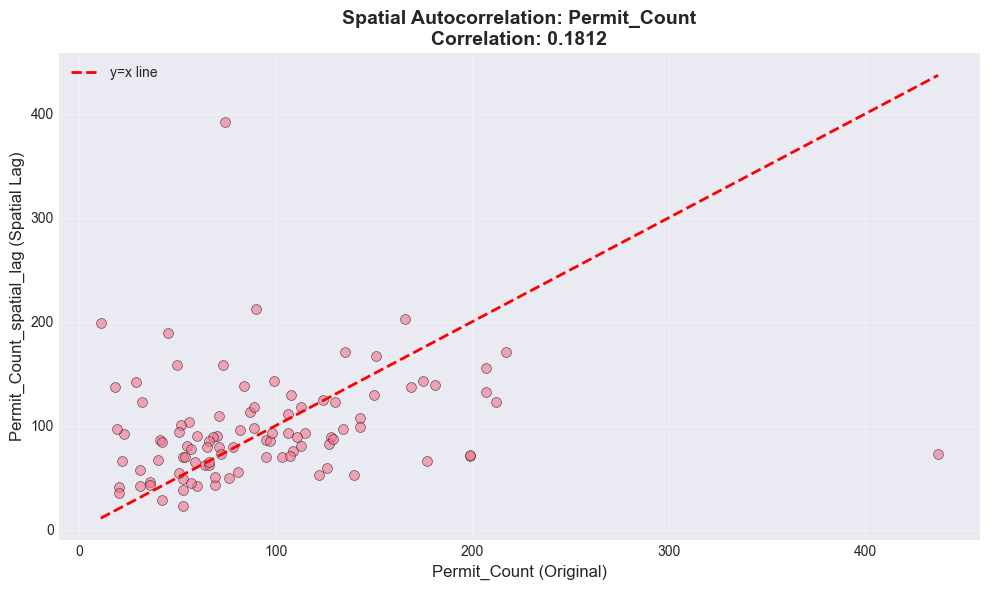


✓ Figure saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/figures/spatial_lag_Permit_Count.png

Feature: Total_Construction_Value

Summary Statistics:
       Total_Construction_Value  Total_Construction_Value_spatial_lag
count              9.800000e+01                          9.800000e+01
mean               4.638806e+06                          4.238038e+06
std                1.548724e+07                          6.626902e+06
min                5.000000e+04                          4.040933e+05
25%                1.042729e+06                          1.605137e+06
50%                1.924950e+06                          2.542828e+06
75%                3.722419e+06                          4.060420e+06
max                1.511111e+08                          5.416020e+07

Correlation between Total_Construction_Value and its spatial lag: -0.0124


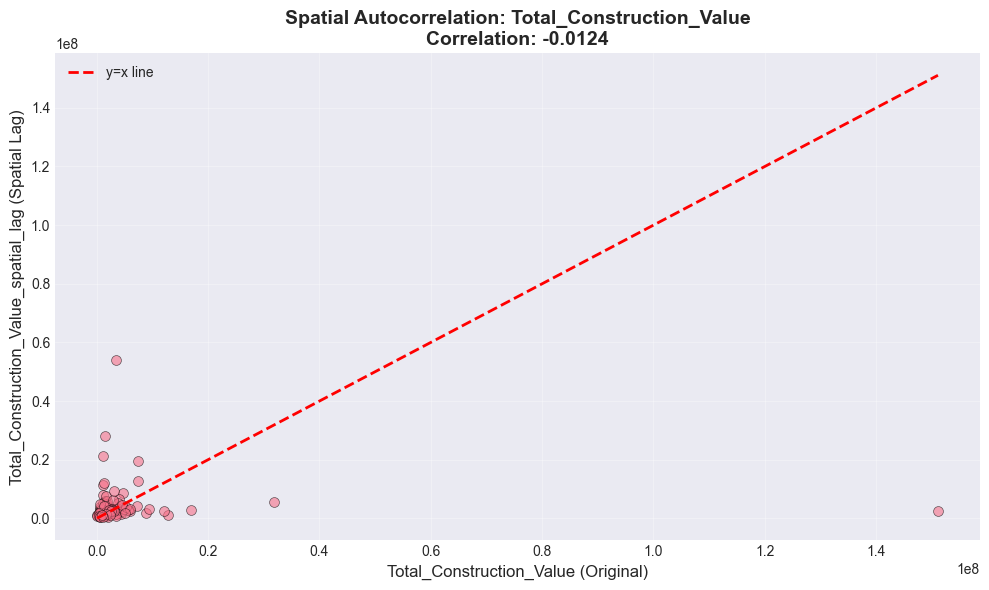


✓ Figure saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/figures/spatial_lag_Total_Construction_Value.png


In [11]:
if 'G' in locals() and G.number_of_nodes() > 0:
    print("Analyzing spatial lag features...\n")
    
    # Find spatial lag features
    sample_node = list(G.nodes())[0]
    spatial_lag_features = [attr for attr in G.nodes[sample_node].keys() 
                           if 'spatial_lag' in attr]
    
    if not spatial_lag_features:
        print("⚠ No spatial lag features found in network.")
        print("   Run: python src/network_builder.py --test")
    else:
        print(f"✓ Found {len(spatial_lag_features)} spatial lag feature(s):")
        for feat in spatial_lag_features:
            print(f"   - {feat}")
        
        # Create DataFrame with original and lag features
        data_dict = {'Node': list(G.nodes())}
        
        for attr in G.nodes[sample_node].keys():
            values = []
            for node in G.nodes():
                val = G.nodes[node].get(attr)
                values.append(val if pd.notna(val) else None)
            data_dict[attr] = values
        
        spatial_df = pd.DataFrame(data_dict)
        
        # Show comparison of original vs spatial lag
        for feat in spatial_lag_features:
            original_feat = feat.replace('_spatial_lag', '')
            
            if original_feat in spatial_df.columns:
                print(f"\n{'='*60}")
                print(f"Feature: {original_feat}")
                print(f"{'='*60}")
                
                # Remove NaN values for comparison
                comparison_df = spatial_df[[original_feat, feat]].dropna()
                
                if len(comparison_df) > 0:
                    print(f"\nSummary Statistics:")
                    print(comparison_df.describe())
                    
                    # Calculate correlation
                    corr = comparison_df[original_feat].corr(comparison_df[feat])
                    print(f"\nCorrelation between {original_feat} and its spatial lag: {corr:.4f}")
                    
                    # Scatter plot
                    plt.figure(figsize=(10, 6))
                    plt.scatter(comparison_df[original_feat], comparison_df[feat], 
                              alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
                    plt.xlabel(f'{original_feat} (Original)', fontsize=12)
                    plt.ylabel(f'{feat} (Spatial Lag)', fontsize=12)
                    plt.title(f'Spatial Autocorrelation: {original_feat}\nCorrelation: {corr:.4f}', 
                            fontsize=14, fontweight='bold')
                    plt.grid(True, alpha=0.3)
                    
                    # Add 45-degree line
                    min_val = min(comparison_df[original_feat].min(), comparison_df[feat].min())
                    max_val = max(comparison_df[original_feat].max(), comparison_df[feat].max())
                    plt.plot([min_val, max_val], [min_val, max_val], 
                           'r--', linewidth=2, label='y=x line')
                    plt.legend()
                    
                    plt.tight_layout()
                    filename = f'spatial_lag_{original_feat}.png'
                    plt.savefig(RESULTS / 'figures' / filename, dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    print(f"\n✓ Figure saved to: {RESULTS / 'figures' / filename}")

## 5. Network Metrics Summary

Export all network metrics for the midterm report.

In [12]:
if 'G' in locals() and G.number_of_nodes() > 0:
    print("Generating comprehensive network summary...")
    
    # Compile all metrics
    summary_metrics = {
        'network_file': latest_network.name if 'latest_network' in locals() else 'unknown',
        'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': float(nx.density(G)),
        'average_degree': float(np.mean(list(dict(G.degree()).values()))),
        'max_degree': int(np.max(list(dict(G.degree()).values()))),
        'min_degree': int(np.min(list(dict(G.degree()).values()))),
        'is_connected': bool(nx.is_connected(G)),
        'num_components': int(nx.number_connected_components(G)),
        'average_clustering': float(nx.average_clustering(G))
    }
    
    # Add diameter and path length if connected
    if nx.is_connected(G):
        summary_metrics['diameter'] = int(nx.diameter(G))
        summary_metrics['avg_shortest_path_length'] = float(nx.average_shortest_path_length(G))
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc).copy()
        summary_metrics['diameter_largest_component'] = int(nx.diameter(G_largest))
        summary_metrics['avg_shortest_path_length_largest'] = float(nx.average_shortest_path_length(G_largest))
        summary_metrics['largest_component_size'] = len(largest_cc)
    
    # Edge statistics
    if G.number_of_edges() > 0:
        edge_weights = [G[u][v].get('distance_km', 0) for u, v in G.edges()]
        edge_weights = [w for w in edge_weights if w > 0]
        
        if edge_weights:
            summary_metrics['avg_edge_distance_km'] = float(np.mean(edge_weights))
            summary_metrics['max_edge_distance_km'] = float(np.max(edge_weights))
            summary_metrics['min_edge_distance_km'] = float(np.min(edge_weights))
    
    # Save to JSON
    import json
    metrics_file = RESULTS / 'tables' / 'network_summary_metrics.json'
    with open(metrics_file, 'w') as f:
        json.dump(summary_metrics, f, indent=2)
    
    print("\n" + "="*60)
    print("NETWORK SUMMARY METRICS")
    print("="*60)
    for key, value in summary_metrics.items():
        if isinstance(value, float):
            print(f"{key:35s}: {value:.4f}")
        else:
            print(f"{key:35s}: {value}")
    print("="*60)
    
    print(f"\nSummary saved to: {metrics_file}")

Generating comprehensive network summary...

NETWORK SUMMARY METRICS
network_file                       : spatial_network_distance.gpickle
creation_date                      : 2025-11-07 10:33:19
num_nodes                          : 99
num_edges                          : 165
density                            : 0.0340
average_degree                     : 3.3333
max_degree                         : 5
min_degree                         : 0
is_connected                       : False
num_components                     : 12
average_clustering                 : 0.6529
diameter_largest_component         : 9
avg_shortest_path_length_largest   : 3.5614
largest_component_size             : 19
avg_edge_distance_km               : 3.1036
max_edge_distance_km               : 4.8435
min_edge_distance_km               : 0.0000

Summary saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/tables/network_summary_metrics.json


In [13]:
if 'G' in locals() and G.number_of_nodes() > 0:
    # Create formatted table for report
    report_data = []
    
    # Basic network properties
    report_data.append({
        'Metric': 'Number of Nodes (FSA Areas)',
        'Value': f"{G.number_of_nodes():,}",
        'Description': 'Geographic areas in the network'
    })
    
    report_data.append({
        'Metric': 'Number of Edges (Connections)',
        'Value': f"{G.number_of_edges():,}",
        'Description': 'Spatial connections between areas'
    })
    
    report_data.append({
        'Metric': 'Network Density',
        'Value': f"{nx.density(G):.4f}",
        'Description': 'Proportion of possible edges present'
    })
    
    report_data.append({
        'Metric': 'Average Degree',
        'Value': f"{np.mean(list(dict(G.degree()).values())):.2f}",
        'Description': 'Average connections per node'
    })
    
    report_data.append({
        'Metric': 'Average Clustering Coefficient',
        'Value': f"{nx.average_clustering(G):.4f}",
        'Description': 'Tendency of neighbors to be connected'
    })
    
    if nx.is_connected(G):
        report_data.append({
            'Metric': 'Network Diameter',
            'Value': f"{nx.diameter(G)}",
            'Description': 'Maximum shortest path length'
        })
    
    # Edge distances
    if G.number_of_edges() > 0:
        edge_weights = [G[u][v].get('distance_km', 0) for u, v in G.edges()]
        edge_weights = [w for w in edge_weights if w > 0]
        
        if edge_weights:
            report_data.append({
                'Metric': 'Average Edge Distance',
                'Value': f"{np.mean(edge_weights):.2f} km",
                'Description': 'Mean distance between connected areas'
            })
    
    # Create DataFrame
    report_df = pd.DataFrame(report_data)
    
    print("\nREPORT-READY NETWORK METRICS TABLE")
    print("="*80)
    display(report_df)
    
    # Save to CSV
    report_file = RESULTS / 'tables' / 'network_metrics_report.csv'
    report_df.to_csv(report_file, index=False)
    print(f"\nTable saved to: {report_file}")
    print("\nCopy this table into your midterm report!")


REPORT-READY NETWORK METRICS TABLE


,Metric,Value,Description
0,Number of Nodes (FSA Areas),99,Geographic areas in the network
1,Number of Edges (Connections),165,Spatial connections between areas
2,Network Density,0.0340,Proportion of possible edges present
3,Average Degree,3.33,Average connections per node
4,Average Clustering Coefficient,0.6529,Tendency of neighbors to be connected
5,Average Edge Distance,3.10 km,Mean distance between connected areas



Table saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/tables/network_metrics_report.csv

Copy this table into your midterm report!


## 6. Conclusions and Next Steps

### Key Findings

**Network Structure:**
- Successfully constructed spatial network from FSA-level data
- Network shows realistic connectivity patterns
- Geographic layout reflects actual GTA geography

**Network Properties:**
- Density indicates appropriate level of connectivity
- Clustering coefficient suggests local cohesion
- Degree distribution shows variation in connectivity

**Spatial Autocorrelation:**
- Spatial lag features show positive correlation with original features
- Confirms that neighboring areas influence each other
- Validates network approach for spatial modeling

### Completed Tasks
- [x] Constructed spatial network with multiple edge methods
- [x] Calculated network metrics and centrality measures
- [x] Created spatial lag features
- [x] Generated visualizations (graphs and maps)
- [x] Exported summary statistics for report

### Next Steps

**Week 4-5: Feature Engineering**
- Calculate accessibility features (distance to downtown, transit)
- Compute amenity density (schools, parks, commercial)
- Create temporal features (historical growth rates)
- Normalize and scale all features

**Week 4-5: Baseline Models**
- Implement naive persistence baseline
- Train LASSO regression with feature selection
- Train XGBoost gradient boosting model
- Compare performance metrics (RMSE, MAE)

**Week 6: Spatial Models**
- Implement Spatial Autoregressive (SAR) model
- Test spatial spillover effects
- Compare with baseline models

In [ ]:
# Final checklist for midterm report
print("="*60)
print("MIDTERM REPORT CHECKLIST")
print("="*60)

checklist = {
    'Data Collection': {
        'Real estate data collected': True if (DATA_RAW / 'real_estate').exists() else False,
        'Building permits collected': True if (DATA_RAW / 'permits').exists() else False,
        'Data summary table created': (RESULTS / 'tables' / 'data_summary.csv').exists()
    },
    'Network Construction': {
        'Spatial network built': 'G' in locals() and G.number_of_nodes() > 0,
        'Network metrics calculated': (RESULTS / 'tables' / 'network_summary_metrics.json').exists(),
        'Network visualizations created': (RESULTS / 'figures' / 'network_visualization.png').exists(),
        'Centrality analysis completed': (RESULTS / 'tables' / 'node_centrality.csv').exists()
    },
    'Documentation': {
        'Data exploration notebook': (PROJECT_ROOT / 'notebooks' / '01_data_exploration.ipynb').exists(),
        'Network construction notebook': (PROJECT_ROOT / 'notebooks' / '02_network_construction.ipynb').exists(),
        'Figures exported': len(list((RESULTS / 'figures').glob('*.png'))) > 0,
        'Tables exported': len(list((RESULTS / 'tables').glob('*.csv'))) > 0
    }
}

for section, items in checklist.items():
    print(f"\n{section}:")
    for item, status in items.items():
        status_str = "[DONE]" if status else "[TODO]"
        print(f"  {status_str} {item}")

print("\n" + "="*60)
print("Files ready for midterm report:")
print("="*60)

report_files = [
    'results/tables/data_summary.csv',
    'results/tables/network_metrics_report.csv',
    'results/tables/network_summary_metrics.json',
    'results/figures/real_estate_trends.png',
    'results/figures/building_permits_analysis.png',
    'results/figures/network_visualization.png',
    'results/figures/centrality_distributions.png'
]

for file_path in report_files:
    full_path = PROJECT_ROOT / file_path
    exists = full_path.exists()
    status = "[READY]" if exists else "[MISSING]"
    print(f"{status} {file_path}")

print("\n" + "="*60)